<a href="https://colab.research.google.com/github/anko191/Python_Kaggle/blob/master/Pytorch/LearningPytorch_4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN（Convolutional Neural Network)

CNNの基礎

1.   畳み込み
2.   プーリング
3.   全結合層からなる処理を実装
4.   特徴量を抽出
5.   画像の認識をして分類



In [1]:
# Convolutional Neural Network
# MNIST データ 読み込み
# pytorch datasetでダウンロードしてくれるかも
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
# 画像ファイルを読み込むための準備(Channel x H x W)
transform = transforms.Compose([
        transforms.ToTensor()
])

# MNISTデータセットのダウンロード
train = torchvision.datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transform
)

print(len(train), type(train))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
60000 <class 'torchvision.datasets.mnist.MNIST'>






/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [2]:
train[0][0].shape

torch.Size([1, 28, 28])

正解ラベル: 5


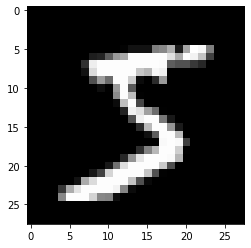

In [3]:
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[0][0], (1,2,0))
# https://note.nkmk.me/python-numpy-transpose/
# shape = (28, 28, 1) になったよ^^^
img = img.reshape(img.shape[0], img.shape[1])
# https://note.nkmk.me/python-numpy-reshape-usage/
# 3 dimension -> 2 dimension
#print(img)
print("正解ラベル:", train[0][1])
plt.imshow(img, cmap='gray')

# 畳み込み(Convolution)

## 必要なハイパーパラメータ



*   入力チャネル:1 (白黒, カラーRGBなら3)
*   出力チャネル:4 (特徴量を抽出するフィルタの数)
*   カーネルサイズ: 3x3
*   ストライド:1 (カーネルをずらすサイズ?)
https://deepage.net/deep_learning/2016/11/07/convolutional_neural_network.html#%E3%82%B9%E3%83%88%E3%83%A9%E3%82%A4%E3%83%89

*   パディング:1 (画像の周りを0埋めサイズ)




In [4]:
#PyTorchではnn.conv2d 1つでok
conv = nn.Conv2d(
    in_channels=1,
    out_channels=4,
    kernel_size=3,
    stride=1,
    padding=1
)
conv, conv.weight, conv.bias

(Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Parameter containing:
 tensor([[[[-0.1150, -0.2726, -0.2930],
           [ 0.0053, -0.1974, -0.1707],
           [-0.0049,  0.2845,  0.2611]]],
 
 
         [[[ 0.3070,  0.2592, -0.0265],
           [ 0.2636, -0.2532,  0.2032],
           [-0.3147, -0.0155, -0.1825]]],
 
 
         [[[-0.0284, -0.1511,  0.2861],
           [ 0.1787, -0.0910,  0.3029],
           [ 0.2312,  0.2315, -0.0909]]],
 
 
         [[[ 0.2457, -0.1332, -0.1353],
           [ 0.1079, -0.1018, -0.0581],
           [ 0.1098,  0.1086, -0.2528]]]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1101, -0.3078, -0.1860, -0.2359], requires_grad=True))

In [5]:
# とりあえず1枚だけ畳み込んでみる?
x = train[0][0]
x = x.reshape(1,1,28,28)
x = conv(x)

In [6]:
x.shape
# カーネルサイズにより、h,wのサイズ変わる
# 畳み込みした4枚の特徴マップも確認できる

torch.Size([1, 4, 28, 28])

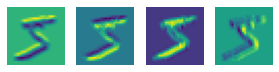

In [7]:
for i in range(4):
    img2 = x[0][i].to('cpu').detach().numpy().copy()
    plt.subplot(1, 5, i+1)
    plt.imshow(img2)
    plt.axis('off')
plt.show()

In [8]:
# プーリング(Pooling)
# 畳み込まれた特徴マップに統計的処理を施して縮小していきます
# MAXプーリングを用いる カーネルサイズ 2x2
# ストライド:2
x = F.max_pool2d(x, kernel_size = 2, stride = 2)
x.shape
# 14 x 14 になっちゃった

torch.Size([1, 4, 14, 14])

# 全結合層

抽出された特徴マップを数値として、1つの次元にまとめてニューラルネットワークに入力

チャネル x H x Wが入力値


<br><br>

(サンプル数, ベクトルの要素数) のサイズに変更すれば、全結合層に入力することができます

In [9]:
x_shape = x.shape[1] * x.shape[2] * x.shape[3] # [784]
x = x.view(-1, x_shape) # [1,784]
# https://www.kikagaku.ai/tutorial/basic_of_computer_vision/learn/pytorch_convolution
# 今回はベクトルの要素数が決まっているため、サンプル数は自動で設定
# -1 とするともう片方の要素に合わせて自動的に設定されます 

In [10]:
x.shape

torch.Size([1, 784])

In [11]:
# 今回は10 クラス分類 (0-9)より 10
fc = nn.Linear(x_shape, 10) # 784 -> 10
x = fc(x)
x
# 5 に対応する 6個目の数値が最も大きくなるように重みとバイアスを学習させていきます

tensor([[ 0.0361,  0.1824,  0.0231,  0.1554, -0.1907, -0.1550, -0.1698,  0.1469,
          0.3242, -0.0206]], grad_fn=<AddmmBackward>)

# Pytorch lightning フレームワークでCNNしましょう

In [12]:
# prepare Dataset
from torchvision import transforms
transforms = transforms.Compose([
        transforms.ToTensor()
])

# データセットの取得
train_val = torchvision.datasets.MNIST(
    root ='.',
    train = True,
    download = True,
    transform = transform
)

test = torchvision.datasets.MNIST(
    root = '.',
    train = False,
    download = True,
    transform = transform
)

# train : val = 80 % : 20 %
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

# データをランダムに分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

In [13]:
# 分割後のサンプルを確認
len(train), len(val), len(test)

(48000, 12000, 10000)

PyTorch Lightningの学習モデルの構築

いじるのは,"class Net" に畳み込みとプーリング処理を追加するだけです

In [14]:
pip install pytorch_lightning

     |████████████████████████████████| 307kB 3.5MB/s 
     |████████████████████████████████| 276kB 10.8MB/s 
     |████████████████████████████████| 829kB 16.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=976d452c7901b40a9407e1031c29a2ae09776f8ee722815bf330b1cbc80494ea
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4fa3ac0fa0398745757d5a932988b80e684ea989eefae3b0d669154222140290
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [20]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
# 学習データ用クラス
class TrainNet(pl.LightningModule):
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)
    
    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        tensorboard_logs = {'train/train_loss': loss, 'train/train_acc': acc} # tensorboard
        results = {'loss': loss, 'log': tensorboard_logs}
        #results = {'loss': loss}
        return results

    
# 検証データ用クラス
class ValidationNet(pl.LightningModule):

    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {'val/avg_loss': avg_loss, 'val/avg_acc': avg_acc}
        results = {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}        
        #results = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

    
# テストデータ用クラス
class TestNet(pl.LightningModule):

    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

    
# 学習データ、検証データ、テストデータクラスの継承クラス
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, input_size=784, hidden_size=100, output_size=10, batch_size=256):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, stride=1)
        self.L1 = nn.Linear(input_size, hidden_size)
        self.L2 = nn.Linear(hidden_size, output_size)
        self.batch_size = batch_size
        self.bn = nn.BatchNorm1d(input_size)
        # これが無かったよ!
    def forward(self, x):
        x = self.conv(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 784)
        x = self.L1(x)
        x = F.relu(x)
        x = self.L2(x)
        return x
    
    def lossfun(self, y, t):
        return F.cross_entropy(y, t)
        #return nn.CrossEntropyLoss(y, t)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.1)

# 画像認識の学習には時間がかかる
Trainerの設定値について注目

*   gpus : cpuでもできなくないけど 100％
*   epoch : デフォルト 1000 になっているので数時間かかる


In [16]:
# gpus使えばいい
# GPUを使えるかどうか確認
torch.cuda.is_available()

True

## epoch
どれくらいがいいのか？

TensorBoardでリアルタイムに確認しながら、途中で止める

途中まで学習したパラメータを再利用できる

In [21]:
# モデルのインスタンス化
net = Net()
net

Net(
  (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (L1): Linear(in_features=784, out_features=100, bias=True)
  (L2): Linear(in_features=100, out_features=10, bias=True)
  (bn): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
# GPUで学習
trainer = Trainer(max_epochs=100, gpus=1)
# モデルの学習
trainer.fit(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name | Type        | Params
-------------------------------------
0 | conv | Conv2d      | 40    
1 | L1   | Linear      | 78 K  
2 | L2   | Linear      | 1 K   
3 | bn   | BatchNorm1d | 1 K   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, 

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

# パラメータを保存して！！！！

### 途中で止めた場合のパラメータを保存したい！

In [26]:
net = net.to('cpu')
torch.save(net.state_dict(), './para.pth')

In [27]:
# 推論
# 保存したパラメータを読み込み

net = Net()
net.load_state_dict(torch.load('para.pth'))

<All keys matched successfully>

正解ラベル:  3


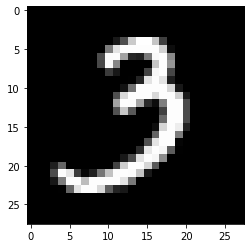

In [29]:
# 適当な画像をテスト
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
sample = test[random.randint(0, 10000)]
sample_label = sample[1]

img = np.transpose(sample[0], (1,2,0))
img = img.reshape(img.shape[0], img.shape[1])
print("正解ラベル: ", sample_label)
plt.imshow(img, cmap='gray')

https://www.kikagaku.ai/tutorial/basic_of_computer_vision/learn/pytorch_convolution

モデルで計算する際には (batchsize, channels, height, width) にする必要があるのでした。

次元を増やす方法はいくつかあるのですが、torch.unsqueeze() を使用します。

引数に次元を増やしたいインデックスを指定します。今回であれば一番最初に次元を増やしたいので、0 とします。

In [31]:
sample_img = sample[0].unsqueeze(0) # [1,28,28] => [1,1,28,28]
y_predict = net.forward(sample_img)
print(y_predict)
print("推論結果:", y_predict.argmax())

tensor([[  0.1534,  -5.2063,   5.5383,  21.3516, -22.6030,   6.2664, -16.3444,
          -6.2381,  -1.2146,   8.3856]], grad_fn=<AddmmBackward>)
推論結果: tensor(3)
